In [ ]:
%pip install -r requirements.txt

In [1]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In this quickstart we'll show you how to build a simple LLM application with LangChain. This application will translate text from English into another language. This is a relatively simple LLM application - it's just a single LLM call plus some prompting. Still, this is a great way to get started with LangChain - a lot of features can be built with just some prompting and an LLM call!

- After reading this tutorial, you'll have a high level overview of:

- Using language models

- Using PromptTemplates and OutputParsers
 
- Using LangChain Expression Language (LCEL) to chain components together
 
- Debugging and tracing your application using LangSmith
 
- Deploying your application with LangServe

In [1]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage


In [2]:
model = ChatOpenAI(model="gpt-3.5-turbo-0125")
messages = [
    SystemMessage(content="Translate the following from Spanish into English"),
    HumanMessage(content="Estoy encargado de analizar datos y crear reportes para la toma de decisiones"),
]

In [3]:
model.invoke(messages)

AIMessage(content='I am in charge of analyzing data and creating reports for decision-making.', response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 38, 'total_tokens': 52}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b23232c2-e61e-4a77-ae84-725e4476e31c-0', usage_metadata={'input_tokens': 38, 'output_tokens': 14, 'total_tokens': 52})

If we've enable LangSmith, we can see that this run is logged to LangSmith, and can see the LangSmith trace
https://smith.langchain.com/o/dda6764c-14f3-533d-94ec-6e5bd07f3600/projects/p/96ac8911-9fa1-4b18-aeae-691ef46b96f6?timeModel=%7B%22duration%22%3A%227d%22%7D&tab=0&Volume=Success&Latency=P50&Tokens=P50&Cost=P50&Streaming=P50&runtab=0&searchModel=%7B%22filter%22%3A%22%22%7D

## OutputParsers

Notice that the response from the model is an AIMessage. This contains a string response along with other metadata about the response. Oftentimes we may just want to work with the string response. We can parse out just this response by using a simple output parser.

We first import the simple output parser.

In [4]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

In [5]:
result=model.invoke(messages)

In [6]:
parser.invoke(result)

'I am in charge of analyzing data and creating reports for decision-making.'

More commonly, we can "chain" the model with this output parser. This means this output parser will get called everytime in this chain. This chain takes on the input type of the language model (string or list of message) and returns the output type of the output parser (string).

We can easily create the chain using the | operator. The | operator is used in LangChain to combine two elements together.

In [10]:
chain = model | parser 

In [11]:
chain.invoke(messages)

'I am in charge of analyzing data and creating reports for decision-making.'

If we now look at LangSmith, we can see that the chain has two steps: first the language model is called, then the result of that is passed to the output parser. We can see the LangSmith trace

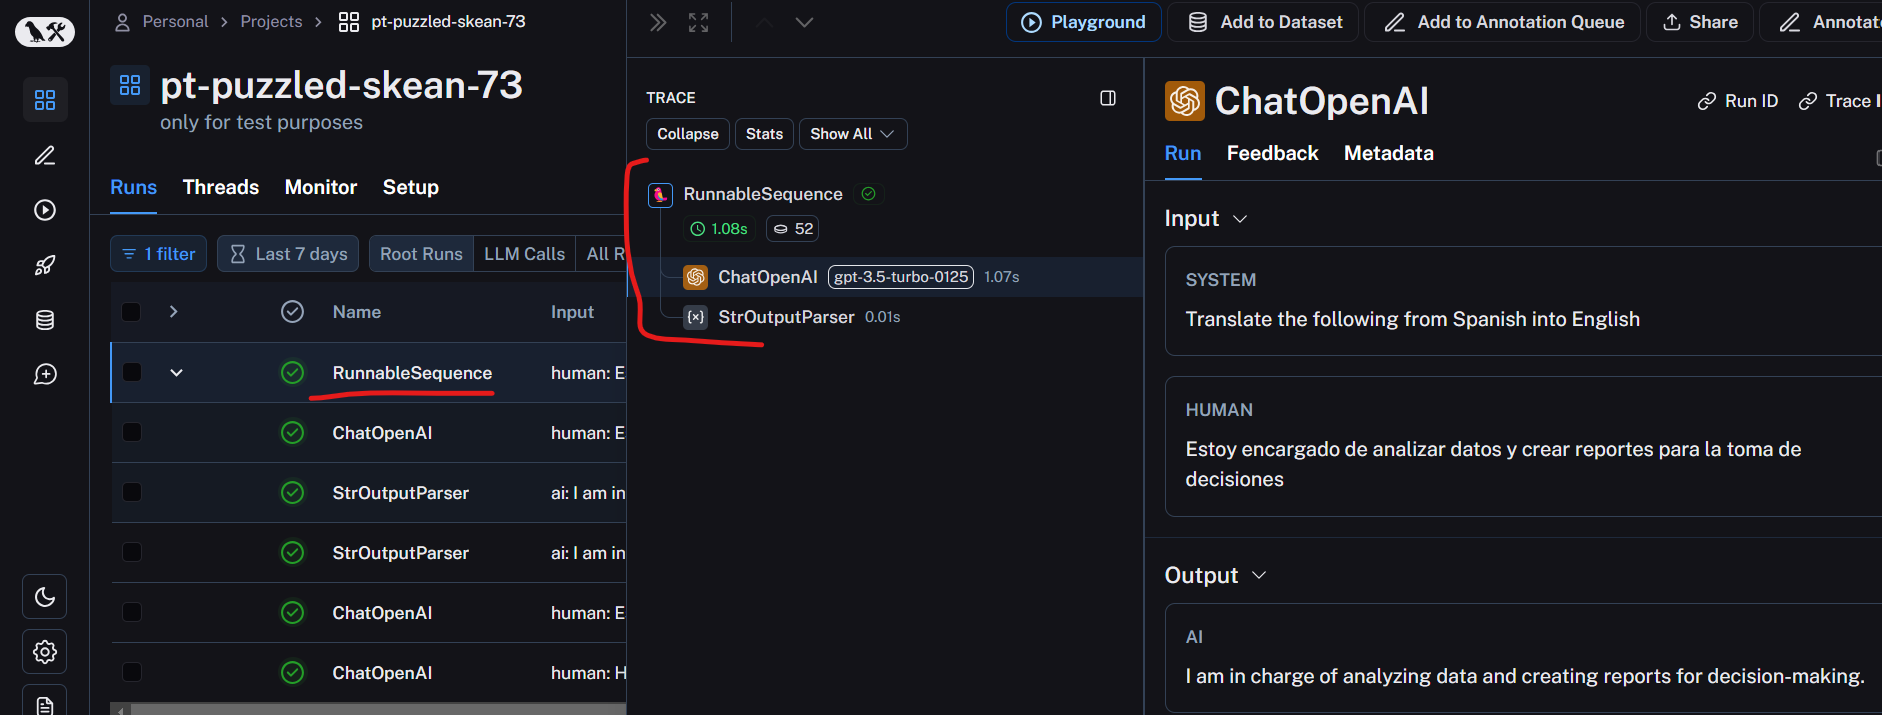
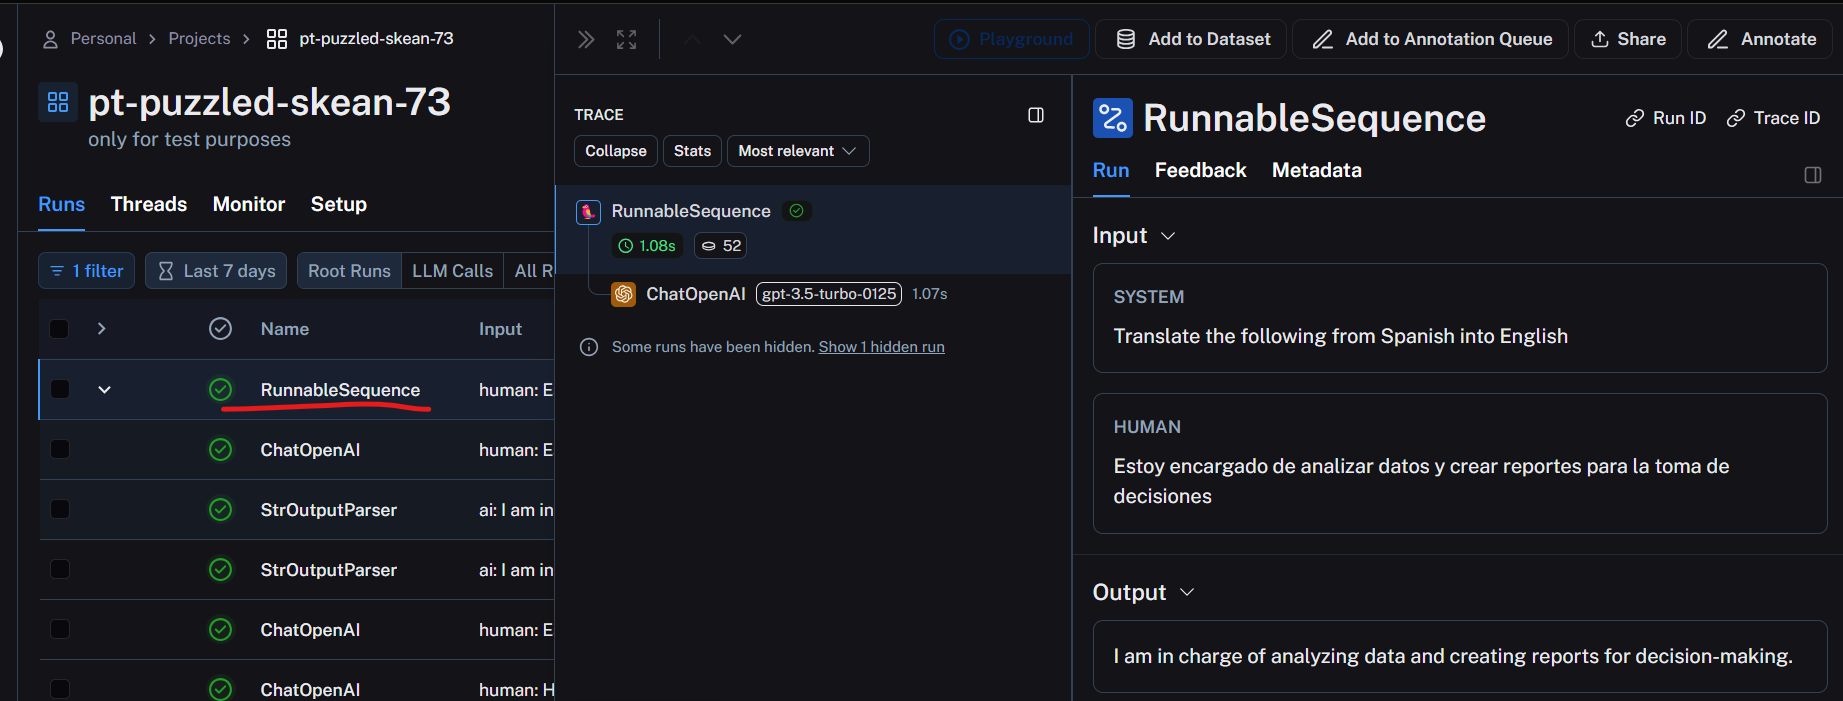

## Prompt Templates

Right now we are passing a list of messages directly into the language model. Where does this list of messages come from? Usually, it is constructed from a combination of user input and application logic. 

This application logic usually takes the raw user input and transforms it into a list of messages ready to pass to the language model. Common transformations include adding a system message or formatting a template with the user input.

PromptTemplates are a concept in LangChain designed to assist with this transformation. They take in raw user input and return data (a prompt) that is ready to pass into a language model.

Let's create a PromptTemplate here. It will take in two user variables:

- language: The language to translate text into
- text: The text to translate

First, let's create a string that we will format to be the system message:

In [7]:
from langchain_core.prompts import ChatPromptTemplate

In [8]:
system_template = "Translate the following into {language}:"

Next, we can create the PromptTemplate. This will be a combination of the system_template as well as a simpler template for where the put the text

In [9]:
prompt_template =ChatPromptTemplate.from_messages( #le pasamos una lista donde cada elemento es una tupla
    [("system",system_template),("user","{text}")]
)

The input to this prompt template is a dictionary. We can play around with this prompt template by itself to see what it does by itself

In [10]:
result=prompt_template.invoke({"text":"Tengo un dron que uso para crear contenido","language":"English"})
result

ChatPromptValue(messages=[SystemMessage(content='Translate the following into English:'), HumanMessage(content='Tengo un dron que uso para crear contenido')])

We can see that it returns a ChatPromptValue that consists of two messages. If we want to access the messages directly we do

In [11]:
result.to_messages()

[SystemMessage(content='Translate the following into English:'),
 HumanMessage(content='Tengo un dron que uso para crear contenido')]

## Chaining together components with LCEL

We can now combine this with the model and the output parser from above using the pipe (|) operator:

In [12]:
chain = prompt_template | model | parser

In [13]:
chain.invoke({"language":"English","text":"En mi tiempo libre me gusta salir con amigos"})

'In my free time, I like to hang out with friends.'

This is a simple example of using LangChain Expression Language (LCEL) to chain together LangChain modules. There are several benefits to this approach, including optimized streaming and tracing support.

If we take a look at the LangSmith trace, we can see all three components show up in the LangSmith trace.

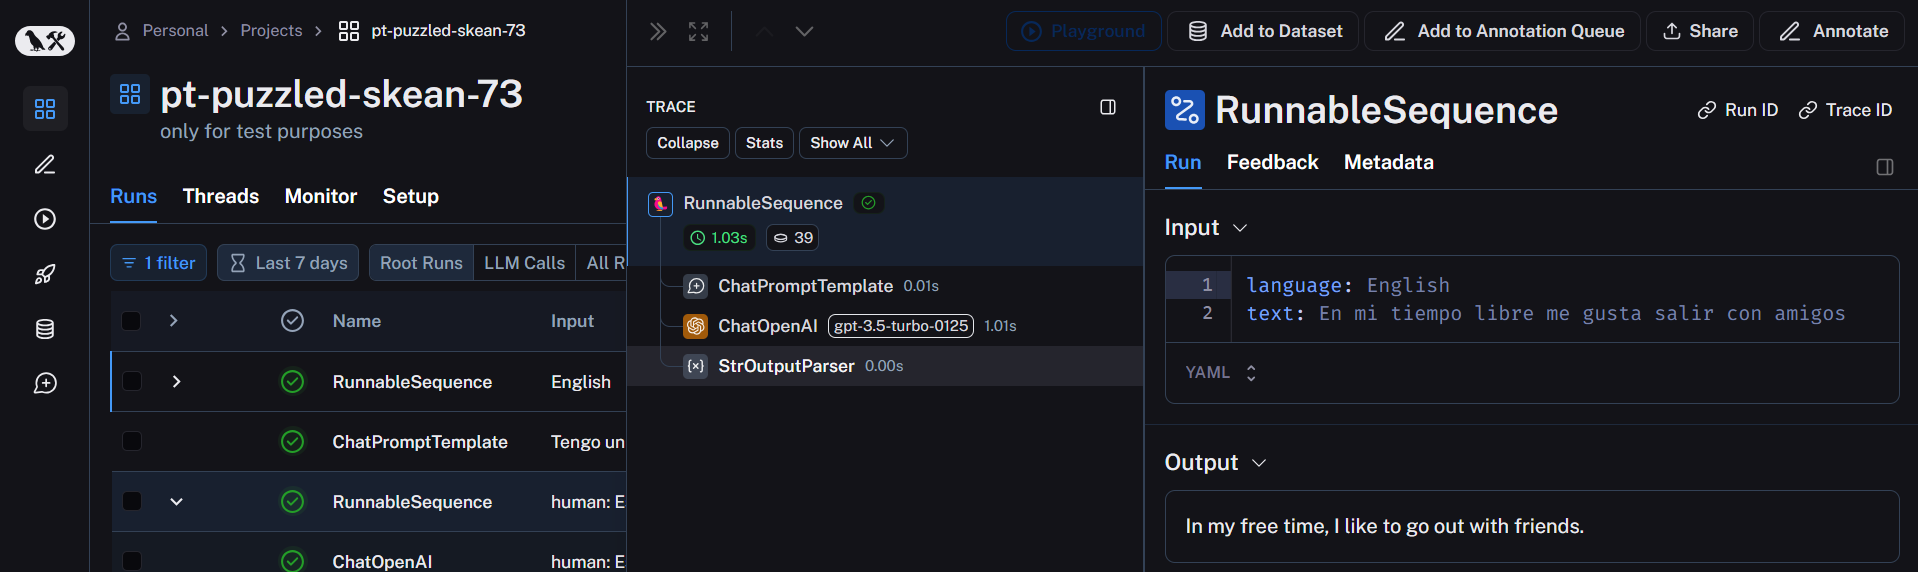

## Serving with LangServe

Now that we've built an application, we need to serve it. That's where LangServe comes in. LangServe helps developers deploy LangChain chains as a REST API. You do not need to use LangServe to use LangChain, but in this guide we'll show how you can deploy your app with LangServe.

While the first part of this guide was intended to be run in a Jupyter Notebook or script, we will now move out of that. We will be creating a Python file and then interacting with it from the command line.

Install with:

In [14]:
%pip install "langserve[all]"

  Using cached sse_starlette-1.8.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
Using cached sse_starlette-1.8.2-py3-none-any.whl (8.9 kB)
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.2 MB 81.9 kB/s eta 0:00:14
   - -------------------------------------- 0.0/1.2 MB 81.9 kB/s eta 0:00:14
   - ----------------------------

## Server

To create a server for our application we'll make a serve.py file. This will contain our logic for serving our application. It consists of three things:

1. The definition of our chain that we just built above
2. Our FastAPI app
3. A definition of a route from which to serve the chain, which is done with langserve.add_routes

if we run server.py and we go to http://localhost:8000/chain/c/N4XyA/playground we can see a simple interface that we can interact with.

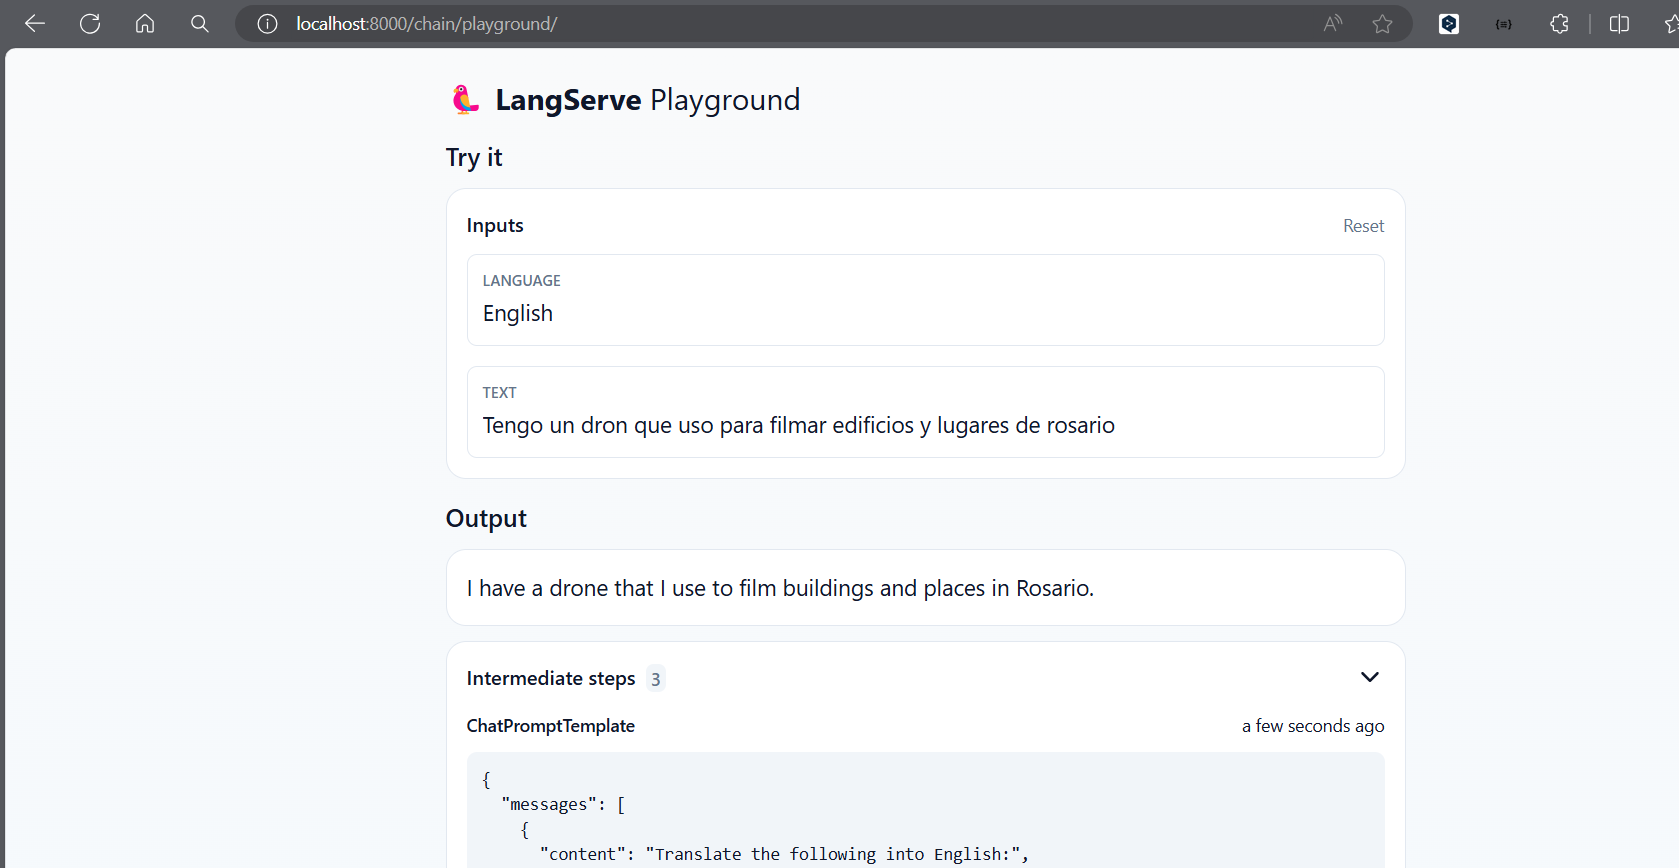

## Client

Now let's set up a client for programmatically interacting with our service. We can easily do this with the [langserve.RemoteRunnable](/docs/langserve/#client). Using this, we can interact with the served chain as if it were running client-side.

In [15]:
from langserve import RemoteRunnable

remote_chain = RemoteRunnable("http://localhost:8000/chain/")
remote_chain.invoke({"language": "english", "text": "Que elegancia la de francia!"})

'What elegance France has!'